# 2 Labelling Stock Relevances

## 2.1 Imports and Dataset Load

In [262]:
# General DS Purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override() # bypassing default pandas_datareader with yfinance Y! API implementation

# Zipfile Support
import glob
import zipfile

#Exports for future use
import pickle

In [85]:
# catch the most recent zip file
lst_zip_files = glob.glob('data/config/*price_comp*') # * means all if need specific format then *.csv
latest_zip_file = max(lst_zip_files, key=os.path.getctime)  
zf = zipfile.ZipFile(latest_zip_file)

In [92]:
# looks for good composition (In Review for Further Checks)
try:
    tickers = pd.read_csv(zf.open("tickers.csv"), usecols=[1]).loc[:,"0"].tolist()
except:
    raise Exception("Sorry. ZIP file with bad structure.")    

In [93]:
csv_files_excluded = ["tickers.csv", "skips_alltimes.csv", "sp500_components_cached.csv"]
data_dict = {f.strip(".csv"): pd.read_csv(zf.open(f), index_col="date", parse_dates=True)["close"].pct_change() for f in zf.namelist() if f not in csv_files_excluded}

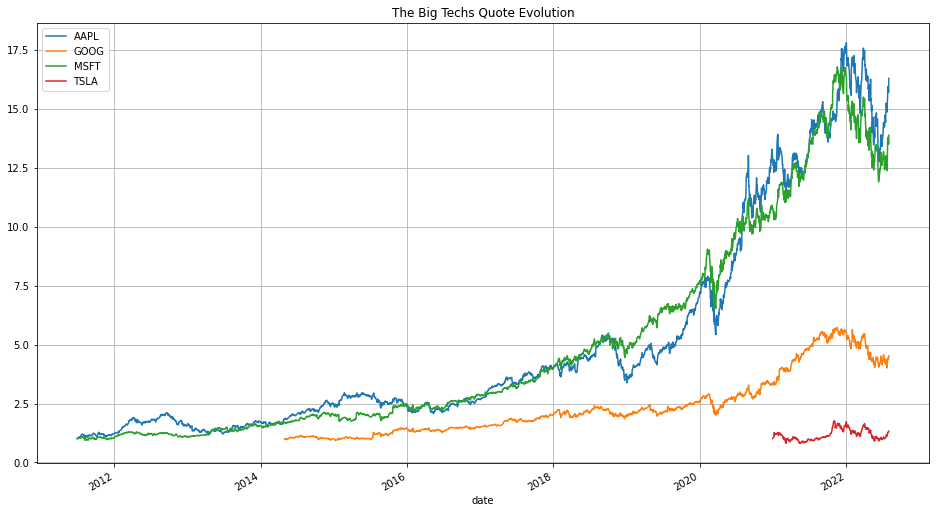

In [260]:
# testing Gross Returns Evolution ($AAPL and other BigTechs Equity Lines shown)
(1+data_dict["AAPL"]).rename("AAPL").cumprod().plot(figsize=(16,9), title="The Big Techs Quote Evolution", legend=True)
(1+data_dict["GOOG"]).rename("GOOG").cumprod().plot(legend=True)
(1+data_dict["MSFT"]).rename("MSFT").cumprod().plot(legend=True)
# New Kid on The Block (TSLA)
(1+data_dict["TSLA"]).rename("TSLA").cumprod().plot(legend=True); # joins SP500 since 2021
plt.grid();

## Resampling Raw Daily Returns

In [102]:
df = pd.DataFrame(data_dict)
df.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2011-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-30,0.010279,0.002528,NaN,NaN,0.004879,NaN,0.007544,NaN,0.008819,NaN,...,0.014655,0.015610,NaN,NaN,0.000181,0.008779,NaN,-0.003321,NaN,NaN
2011-07-01,0.017414,0.028373,NaN,NaN,0.022612,NaN,0.017392,NaN,0.009122,NaN,...,0.011555,0.028818,NaN,NaN,0.027335,0.029905,NaN,0.017076,NaN,NaN
2011-07-05,-0.006539,0.004905,NaN,NaN,0.017975,NaN,0.003799,NaN,0.001130,NaN,...,0.001038,-0.013071,NaN,NaN,-0.002643,-0.010294,NaN,-0.013104,NaN,NaN
2011-07-06,0.003098,-0.009152,NaN,NaN,0.006668,NaN,0.019158,NaN,0.002257,NaN,...,0.007520,0.000000,NaN,NaN,-0.007951,0.002018,NaN,-0.002490,NaN,NaN


In [103]:
def net_cumreturn(data, last_row=False):
    df = ((1+data).cumprod(axis=0)-1)
    if last_row:
        return df.iloc[-1]
    return df

df["AAPL"].resample("BM").apply(net_cumreturn, last_row=True)[:-1] # (Net) Cumulative Return and Monthly Resampling

date
2011-06-30    0.004879
2011-07-29    0.163286
2011-08-31   -0.007462
2011-09-30   -0.009121
2011-10-31    0.054028
                ...   
2022-03-31    0.054457
2022-04-29   -0.097131
2022-05-31   -0.054496
2022-06-30   -0.081430
2022-07-29    0.188634
Freq: BM, Name: AAPL, Length: 134, dtype: float64

After test with `AAPL` let's try with the entire dataframe

In [105]:
df_monthly_returns = df.resample("BM").apply(net_cumreturn, last_row=True)[1:-1]

In [106]:
df_monthly_returns.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2011-07-29,-0.175113,-0.071248,NaN,NaN,0.163286,NaN,-0.074638,NaN,-0.015840,NaN,...,-0.004989,-0.103747,NaN,NaN,-0.039461,-0.050316,NaN,-0.087880,NaN,NaN
2011-08-31,-0.125474,-0.124954,NaN,NaN,-0.007462,NaN,0.036231,NaN,0.031832,NaN,...,-0.070996,-0.120673,NaN,NaN,0.029345,-0.052149,NaN,-0.203123,NaN,NaN
2011-09-30,-0.152428,-0.252344,NaN,NaN,-0.009121,NaN,-0.058363,NaN,-0.026091,NaN,...,-0.126710,-0.155444,NaN,NaN,-0.091595,-0.059940,NaN,-0.192661,NaN,NaN
2011-10-31,0.186240,0.124347,NaN,NaN,0.054028,NaN,0.094714,NaN,0.063066,NaN,...,0.204301,0.173601,NaN,NaN,0.090623,-0.015894,NaN,0.232955,NaN,NaN
2011-11-30,0.011599,-0.070590,NaN,NaN,-0.055783,NaN,-0.086342,NaN,0.004140,NaN,...,-0.022998,0.007976,0.027074,NaN,0.046108,-0.039521,NaN,-0.072600,NaN,NaN


In [107]:
df_monthly_returns.tail()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2022-03-31,0.015112,NaN,0.057971,0.019498,0.054457,0.077717,0.085456,0.065972,-0.026957,NaN,...,-0.088573,NaN,-0.041484,NaN,-0.028248,0.040084,0.000871,-0.075187,NaN,-0.026130
2022-04-29,-0.097278,NaN,0.028493,-0.035418,-0.097131,-0.086248,-0.022106,-0.134827,-0.037239,NaN,...,-0.187525,NaN,-0.052360,NaN,-0.017692,-0.058033,-0.106454,-0.138042,NaN,-0.058485
2022-05-31,0.069506,NaN,-0.047949,-0.048941,-0.054496,0.003336,0.026248,-0.079838,0.034890,NaN,...,-0.010753,NaN,0.046584,NaN,0.043261,-0.004472,-0.085132,0.016414,NaN,-0.035656
2022-06-30,-0.068909,NaN,-0.290431,-0.080321,-0.081430,0.049010,-0.085987,-0.061396,-0.070893,NaN,...,-0.093626,NaN,-0.072047,NaN,-0.065531,-0.124054,-0.130814,-0.107644,NaN,0.005616
2022-07-29,0.131073,NaN,0.081230,0.118609,0.188634,-0.063006,0.031453,0.183831,0.001749,NaN,...,0.012035,NaN,0.177155,NaN,0.079552,0.050733,0.216840,0.071709,NaN,0.063965


A very useful graphical comparison between types of compounding wealth invested depending on sampling frequency

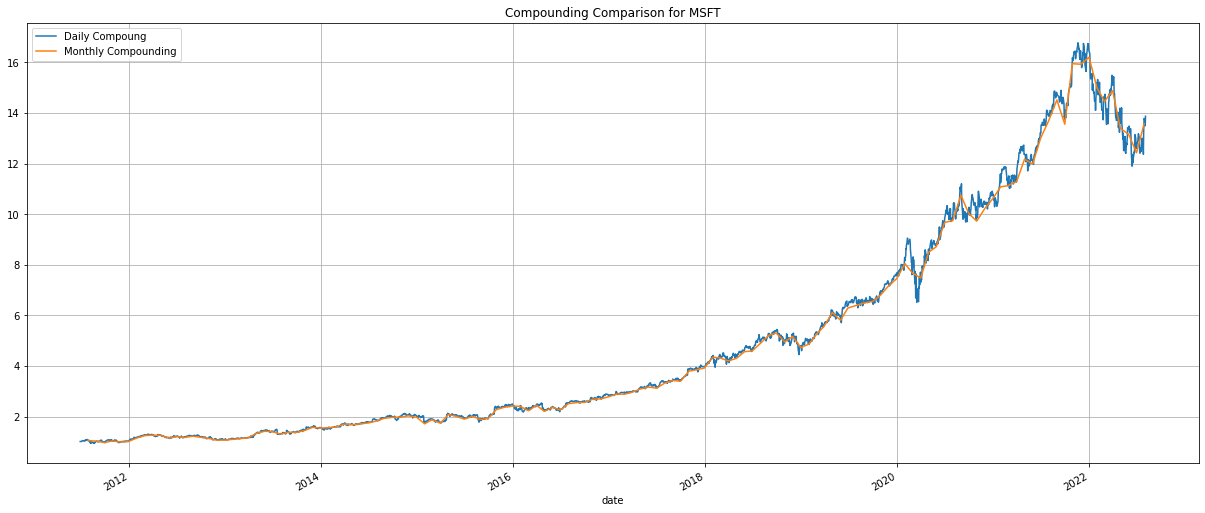

In [109]:
(1+df["MSFT"]).cumprod().rename("Daily Compoung").plot(legend=True)
(1+df_monthly_returns["MSFT"]).cumprod().rename("Monthly Compounding").plot(legend=True, title="Returns Compounding Comparison for Microsoft", figsize=(21,9))
plt.grid();


## Ranking Assets By Monthly Raw Returns Each End Of Month

1) Ranking for each business month end frequency (_BM_). From **LTR** algos perspective, index could be used as a _query_ label:

In [110]:
df_monthly_returns.rank(ascending=False, axis=1)

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2011-07-29,464.0,345.0,NaN,NaN,7.0,NaN,356.0,NaN,176.0,NaN,...,141.0,422.0,NaN,NaN,265.0,286.0,NaN,386.0,NaN,NaN
2011-08-31,374.0,373.0,NaN,NaN,118.0,NaN,45.0,NaN,53.0,NaN,...,267.0,368.0,NaN,NaN,57.0,224.0,NaN,451.0,NaN,NaN
2011-09-30,370.0,456.0,NaN,NaN,78.0,NaN,185.0,NaN,117.0,NaN,...,325.0,376.0,NaN,NaN,261.0,187.0,NaN,417.0,NaN,NaN
2011-10-31,124.0,236.0,NaN,NaN,381.0,NaN,306.0,NaN,357.0,NaN,...,101.0,139.0,NaN,NaN,312.0,458.0,NaN,68.0,NaN,NaN
2011-11-30,179.0,409.0,NaN,NaN,384.0,NaN,429.0,NaN,205.0,NaN,...,301.0,196.0,134.0,NaN,80.0,355.0,NaN,414.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,276.0,NaN,182.0,266.0,191.0,129.0,116.0,154.0,377.0,NaN,...,462.0,NaN,401.0,NaN,380.0,221.0,312.0,446.0,NaN,373.0
2022-04-29,348.0,NaN,61.0,176.0,347.0,323.0,151.0,417.0,180.0,NaN,...,471.0,NaN,220.0,NaN,142.0,236.0,366.0,421.0,NaN,237.0
2022-05-31,94.0,NaN,409.0,411.0,415.0,272.0,197.0,449.0,175.0,NaN,...,307.0,NaN,145.0,NaN,153.0,290.0,452.0,235.0,NaN,382.0


#### Some Useful Checks

In [112]:
df_monthly_returns.rank(ascending=False, axis=1).iloc[0].sort_values(ascending=True).head(10) # First End-Of-Month Ranking

WPI       1.0
CVC       2.0
EQT       3.0
GOOGL     4.0
RRC       5.0
APOL      6.0
AAPL      7.0
CHK       8.0
URBN      9.0
ETFC     10.0
Name: 2011-07-29 00:00:00, dtype: float64

In [113]:
df_monthly_returns.iloc[0].sort_values(ascending=False).head(10) # Checking the Rank is Meaningful

WPI      0.428571
CVC      0.315244
EQT      0.208683
GOOGL    0.192168
RRC      0.174054
APOL     0.163690
AAPL     0.163286
CHK      0.157164
URBN     0.155950
ETFC     0.150725
Name: 2011-07-29 00:00:00, dtype: float64

#### **Tresholds definition**

Playing with tresholds definitions

a) The Top10 Worst Performers (First End Of Month):

In [114]:
df_monthly_returns.iloc[0][df_monthly_returns.iloc[0].rank(ascending=True)<=10].rank(ascending=True).sort_values()

EP       1.0
JNPR     2.0
AKAM     3.0
AKS      4.0
S        5.0
IPG      6.0
MWW      7.0
GNW      8.0
FLIR     9.0
AVY     10.0
Name: 2011-07-29 00:00:00, dtype: float64

b) The Top10 Best Performers (First End of Month)

In [115]:
df_monthly_returns.iloc[0][df_monthly_returns.iloc[0].rank(ascending=False)<=10].rank(ascending=False).sort_values()

WPI       1.0
CVC       2.0
EQT       3.0
GOOGL     4.0
RRC       5.0
APOL      6.0
AAPL      7.0
CHK       8.0
URBN      9.0
ETFC     10.0
Name: 2011-07-29 00:00:00, dtype: float64

c)  Let's Score Them

In [116]:
df_test = df_monthly_returns.copy()

In [117]:
df_row = df_test.iloc[0]

In [118]:
best_perfs = df_row.rank(ascending=False)<=10
worst_perfs = df_row.rank(ascending=True)<=10

In [121]:
df_row[worst_perfs].sort_values()

EP     -0.300000
JNPR   -0.257461
AKAM   -0.230378
AKS    -0.229061
S      -0.215213
IPG    -0.215200
MWW    -0.199181
GNW    -0.190661
FLIR   -0.185405
AVY    -0.183278
Name: 2011-07-29 00:00:00, dtype: float64

In [122]:
df_row[best_perfs].sort_values(ascending=False)

WPI      0.428571
CVC      0.315244
EQT      0.208683
GOOGL    0.192168
RRC      0.174054
APOL     0.163690
AAPL     0.163286
CHK      0.157164
URBN     0.155950
ETFC     0.150725
Name: 2011-07-29 00:00:00, dtype: float64

An example of single row simple scorer

In [123]:
df_row.loc[best_perfs] = 1 # High Positive Relevance 
df_row.loc[worst_perfs] = -1 # High Negative Relevance
df_row.loc[~best_perfs & ~worst_perfs] = 0 # Irrelevant for Trading
df_row

A       0.0
AA      0.0
AAL     0.0
AAP     0.0
AAPL    1.0
       ... 
ZBH     0.0
ZBRA    0.0
ZION    0.0
ZMH     0.0
ZTS     0.0
Name: 2011-07-29 00:00:00, Length: 755, dtype: float64

In [124]:
df_row[df_row!=0].count()

20

In [125]:
#More Relevants
df_row[df_row==1]

AAPL     1.0
APOL     1.0
CHK      1.0
CVC      1.0
EQT      1.0
ETFC     1.0
GOOGL    1.0
RRC      1.0
URBN     1.0
WPI      1.0
Name: 2011-07-29 00:00:00, dtype: float64

In [127]:
df_row[df_row==-1]

AKAM   -1.0
AKS    -1.0
AVY    -1.0
EP     -1.0
FLIR   -1.0
GNW    -1.0
IPG    -1.0
JNPR   -1.0
MWW    -1.0
S      -1.0
Name: 2011-07-29 00:00:00, dtype: float64

d) Therefore, we are able to **construct a minimal viable scorer**:

In [129]:
df_monthly_ranks = df_monthly_returns.rank(ascending=False, axis=1)

In [130]:
df_monthly_ranks.iloc[0].sort_values().head(10)

WPI       1.0
CVC       2.0
EQT       3.0
GOOGL     4.0
RRC       5.0
APOL      6.0
AAPL      7.0
CHK       8.0
URBN      9.0
ETFC     10.0
Name: 2011-07-29 00:00:00, dtype: float64

In [191]:
df_rank_encoded = df_monthly_ranks.copy()
df_rank_encoded.head(10)

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2011-07-29,464.0,345.0,NaN,NaN,7.0,NaN,356.0,NaN,176.0,NaN,...,141.0,422.0,NaN,NaN,265.0,286.0,NaN,386.0,NaN,NaN
2011-08-31,374.0,373.0,NaN,NaN,118.0,NaN,45.0,NaN,53.0,NaN,...,267.0,368.0,NaN,NaN,57.0,224.0,NaN,451.0,NaN,NaN
2011-09-30,370.0,456.0,NaN,NaN,78.0,NaN,185.0,NaN,117.0,NaN,...,325.0,376.0,NaN,NaN,261.0,187.0,NaN,417.0,NaN,NaN
2011-10-31,124.0,236.0,NaN,NaN,381.0,NaN,306.0,NaN,357.0,NaN,...,101.0,139.0,NaN,NaN,312.0,458.0,NaN,68.0,NaN,NaN
2011-11-30,179.0,409.0,NaN,NaN,384.0,NaN,429.0,NaN,205.0,NaN,...,301.0,196.0,134.0,NaN,80.0,355.0,NaN,414.0,NaN,NaN
2011-12-30,412.0,461.0,NaN,NaN,70.0,NaN,267.0,NaN,168.0,NaN,...,343.0,304.0,35.0,NaN,94.0,78.0,NaN,239.0,NaN,NaN
2012-01-31,19.0,36.0,NaN,NaN,80.0,NaN,240.0,NaN,408.0,NaN,...,160.0,400.0,337.0,NaN,161.0,69.0,NaN,274.0,NaN,NaN
2012-02-29,259.0,340.0,NaN,NaN,15.0,NaN,429.0,NaN,207.0,NaN,...,268.0,162.0,344.0,NaN,206.0,357.0,NaN,46.0,NaN,NaN
2012-03-30,256.0,386.0,NaN,NaN,32.0,NaN,128.0,NaN,58.0,NaN,...,193.0,385.0,83.0,NaN,76.0,107.0,NaN,17.0,NaN,NaN


The following function, bins (encodes) rank into a performance class of stocks. 

We remark that depending each particular end of month, categories could have more or less stocks.

In [192]:
# notna values. This implies trading with a different number of high relevant (CAT 1) and high irrelevant (CAT 20) stocks on each "query" date
def revelator(data): #John, The Revelator
    bins = 20
    df = pd.cut(x=data, bins=bins, labels=False)
    return 1+df
""" 
Relevance encoding must be lagged : to train the model we have to calculate and select features 
capable to explain the one-period (1 BM) after high or low performance
In this way relevances can be inferred by the model on the test set (prediction) 
and then implement portfolio selection policies prior to the period of interest 
"""
df_rank_encoded = df_rank_encoded.apply(revelator, axis=1).shift(-1)
df_rank_encoded

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2011-07-29,16.0,16.0,NaN,NaN,5.0,NaN,2.0,NaN,3.0,NaN,...,12.0,16.0,NaN,NaN,3.0,10.0,NaN,20.0,NaN,NaN
2011-08-31,16.0,20.0,NaN,NaN,4.0,NaN,8.0,NaN,5.0,NaN,...,14.0,16.0,NaN,NaN,11.0,8.0,NaN,18.0,NaN,NaN
2011-09-30,6.0,10.0,NaN,NaN,17.0,NaN,13.0,NaN,16.0,NaN,...,5.0,6.0,NaN,NaN,14.0,20.0,NaN,3.0,NaN,NaN
2011-10-31,8.0,18.0,NaN,NaN,17.0,NaN,19.0,NaN,9.0,NaN,...,13.0,9.0,6.0,NaN,4.0,15.0,NaN,18.0,NaN,NaN
2011-11-30,18.0,20.0,NaN,NaN,3.0,NaN,12.0,NaN,8.0,NaN,...,15.0,13.0,2.0,NaN,4.0,4.0,NaN,11.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,14.0,NaN,3.0,7.0,14.0,13.0,6.0,17.0,8.0,NaN,...,19.0,NaN,9.0,NaN,6.0,10.0,15.0,17.0,NaN,10.0
2022-04-29,4.0,NaN,17.0,17.0,17.0,11.0,8.0,18.0,7.0,NaN,...,13.0,NaN,6.0,NaN,7.0,12.0,18.0,10.0,NaN,16.0
2022-05-31,9.0,NaN,20.0,9.0,10.0,1.0,10.0,8.0,9.0,NaN,...,11.0,NaN,9.0,NaN,8.0,14.0,15.0,13.0,NaN,2.0


In [193]:
df_rank_encoded.iloc[0][df_rank_encoded.iloc[0].notna()].sort_values(ascending=True).head(40)

KMB      1.0
AN       1.0
SO       1.0
MA       1.0
RAI      1.0
AZO      1.0
EW       1.0
EP       1.0
ED       1.0
ECL      1.0
WPI      1.0
NI       1.0
BMY      1.0
DISCA    1.0
MO       1.0
NEM      1.0
MTZ      1.0
CF       1.0
AMGN     1.0
ORLY     1.0
CL       1.0
SRCL     1.0
AEP      1.0
INTU     1.0
PWR      2.0
SRE      2.0
VZ       2.0
AEE      2.0
MCD      2.0
POM      2.0
WIN      2.0
PG       2.0
WEC      2.0
DUK      2.0
PNW      2.0
WM       2.0
PEP      2.0
HUM      2.0
ABC      2.0
PPL      2.0
Name: 2011-07-29 00:00:00, dtype: float64

In [194]:
df_rank_encoded.tail()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2022-03-31,14.0,NaN,3.0,7.0,14.0,13.0,6.0,17.0,8.0,NaN,...,19.0,NaN,9.0,NaN,6.0,10.0,15.0,17.0,NaN,10.0
2022-04-29,4.0,NaN,17.0,17.0,17.0,11.0,8.0,18.0,7.0,NaN,...,13.0,NaN,6.0,NaN,7.0,12.0,18.0,10.0,NaN,16.0
2022-05-31,9.0,NaN,20.0,9.0,10.0,1.0,10.0,8.0,9.0,NaN,...,11.0,NaN,9.0,NaN,8.0,14.0,15.0,13.0,NaN,2.0
2022-06-30,6.0,NaN,11.0,7.0,2.0,20.0,16.0,2.0,18.0,NaN,...,18.0,NaN,3.0,NaN,11.0,14.0,1.0,12.0,NaN,13.0
2022-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
df_rank_encoded.to_csv("data/monthly_ranks_encoded.csv", na_rep="#N/A", index=True, index_label="Date")

#### Signalling By Category: Long Only Category-based PFolios

In [249]:
# Several masks to select a category of performers (equally weighted scheme) to construct different portfolios

# 1) Extreme Best/Worst Performers
mask1 = df_rank_encoded.shift(1)==1
mask20 = df_rank_encoded.shift(1)==20

# 2) Moderate abnormal stocks
mask8 = df_rank_encoded.shift(1)==8   # Better Than The Median
mask12 = df_rank_encoded.shift(1)==12 # Worst Than the Median

# 3) "Normal" Performers Categories ("Central" Categories)
mask9 = df_rank_encoded.shift(1)==9
mask10 = df_rank_encoded.shift(1)==10
mask11 = df_rank_encoded.shift(1)==11

In [207]:
# Assets Composing The First (Ideal) Allocation of Training Period
print(df_rank_encoded.shift(1).iloc[1][df_rank_encoded.shift(1).iloc[1]==1].index.tolist())

['AEP', 'AMGN', 'AN', 'AZO', 'BMY', 'CF', 'CL', 'DISCA', 'ECL', 'ED', 'EP', 'EW', 'INTU', 'KMB', 'MA', 'MO', 'MTZ', 'NEM', 'NI', 'ORLY', 'RAI', 'SO', 'SRCL', 'WPI']


**Categorized Long Only portfolio strategies versus Baseline Portfolio (SP500 replica with Low-Survivorship-Bias)**

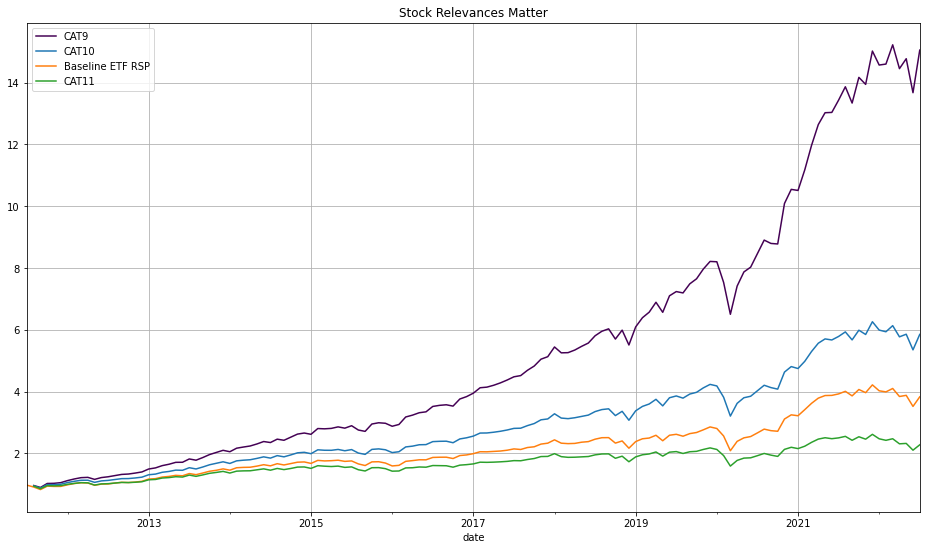

In [243]:
# Equity Line for Equally Weighted Portfolios composed by different class peformers (CAT 9, 10, 11)
(1+df_monthly_returns[mask9].mean(axis=1, skipna=True)).rename("CAT9").cumprod().plot(figsize=(16,9), title="Stock Relevances Matter", legend=True, cmap="viridis")
(1+df_monthly_returns[mask10].mean(axis=1, skipna=True)).rename("CAT10").cumprod().plot(legend=True)
#(1+df_monthly_returns[mask12].mean(axis=1, skipna=True)).rename("CAT12").cumprod().plot(legend=True)
# Baseline ETF biased Replica (0.2% fee p.a.)
(1+df_monthly_returns.mean(axis=1,skipna=True)+0.002/12).rename("Baseline ETF RSP").cumprod().plot(legend=True)
(1+df_monthly_returns[mask11].mean(axis=1, skipna=True)).rename("CAT11").cumprod().plot(legend=True)
plt.grid();


In [230]:
df_rank_encoded.iloc[-2].value_counts()

10.0    26
1.0     26
20.0    26
19.0    25
5.0     25
15.0    25
8.0     25
14.0    25
17.0    25
13.0    25
6.0     25
11.0    25
12.0    25
3.0     25
9.0     25
18.0    25
16.0    25
2.0     25
7.0     25
4.0     25
Name: 2022-06-30 00:00:00, dtype: int64

**Finally** A toy strategy longing better performers than the median (CAT10) and shorting worst performers (CAT12):
_Fees_, _Actual Margin Brokerage Accounts_ and _Organized Markets Restrictions (such as short positions banned)_ are not taken into account.

Obviously this is a TOY trading program. We don't know a priori stock relevances and precisely for that we are intending to use **LTR Machine Learning** in order to _anticipate_ (via training these **LTR** models) the correct a __posteriori relevances__ (a good and profitable behaviour in test sets).

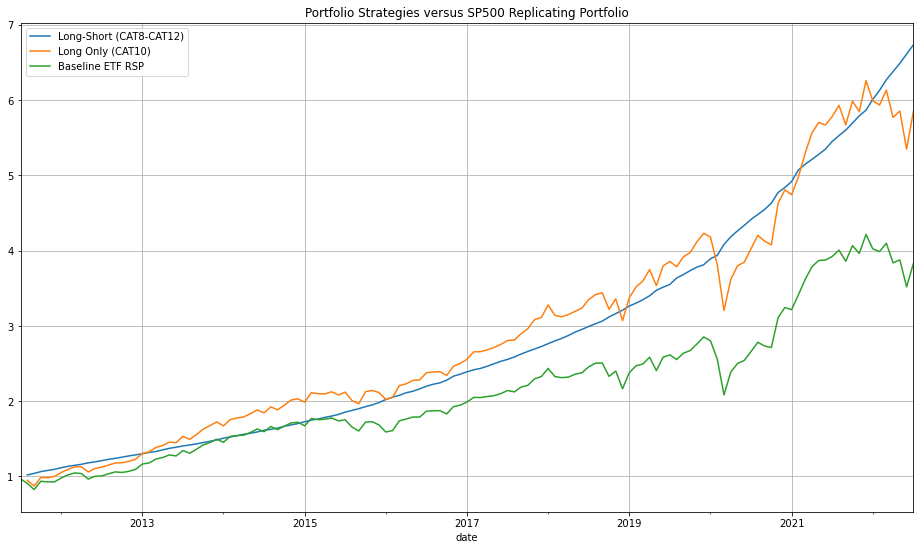

In [253]:
(
    (1+0.5*df_monthly_returns[mask8].mean(axis=1, skipna=True)-0.5*df_monthly_returns[mask12].mean(axis=1, skipna=True)).rename("Long-Short (CAT8-CAT12)")
    .cumprod()
    .plot(legend=True, figsize=(16,9), title="Portfolio Strategies versus SP500 Replicating Portfolio")
)
(1+df_monthly_returns[mask10].mean(axis=1, skipna=True)).rename("Long Only (CAT10)").cumprod().plot(legend=True);
(1+df_monthly_returns.mean(axis=1,skipna=True)+0.002/12).rename("Baseline ETF RSP").cumprod().plot(legend=True)
plt.grid();

### Pkl and CSV Concatenated Exports

After constructing scores and then stock relevances, we proceed to dump the core relevant data for further developments:

#### Pickle Binary

In [264]:
with open("data/config/20220814_price_components_data.pkl", "wb") as f:
    pickle.dump(data_dict, f)

#### CSV File

In [267]:
df.to_csv("data/config/daily_raw_returns_merged.csv", na_rep="#N/A", index=True, index_label="Date")